In [4]:
import os
import math
import ordpy as op
import numpy as np
import pandas as pd
import neurokit2 as nk
import scipy.stats as st
import colorednoise as cn
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy
from PIL import Image, ImageDraw, ImageFont
from statsmodels.tsa.stattools import pacf
from scipy.spatial.distance import jensenshannon
from sklearn.linear_model import LinearRegression
# from data_generation import Binary_Telegraph_Process
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split as tts

In [9]:
class signal2noise(object):
    def __init__(self, seccode, alpha=0.05, n_lags=10):
        
        self.seccode = seccode # seccode + b or s
        self.data    = [] # list-type of factored signal
        self.alpha   = alpha
        self.n_lags  = n_lags
        
        self.pacf_ = []
        self.bart_ = []
        self.poly_s2n_ = []
    
    
    def get_data(self):
    
        for ds in ['60', '30', '15', '5', '1', '11']: #['hour', 'min30', 'min15', 'min5', 'min', 'milsec']:
            dir_path = f'moex_data/{self.seccode[0]}/noises/noise_{self.seccode[1]}_{ds}.csv' #'hf_data/' + ds + ' Si-1222.csv'
            data = pd.read_csv(dir_path)
            data.dropna(subset=['STANDARDIZED_NOISE'], inplace=True)
            X = data['STANDARDIZED_NOISE'].values
            # X = np.nan_to_num(X, posinf=max(X), neginf=min(X))
            self.data.append(X)
           # print(ds, X.shape)
    
    
    def get_pacf(self):
        
        for d in self.data:
            p, ci = pacf(d, nlags=self.n_lags, alpha=self.alpha)
            self.pacf_.append(p)
        self.pacf_ = np.array(self.pacf_)
    
    
    def get_bartlett(self):
        
        for i in range(len(self.data)):
            factor = 1 if i == len(self.data)-1 else len(self.data[i])/len(self.data[i+1])
            self.bart_.append(1 - norm.cdf(self.pacf_[i], scale=1./np.sqrt(len(self.data[i]) / factor)))
        self.bart_ = np.array(self.bart_)
        
    
    def get_ent_comp(self):
        
        self.ent_comp_ = np.array([op.complexity_entropy(d) for d in self.data])
        self.ec_min_ = op.minimum_complexity_entropy()
        self.ec_max_ = op.maximum_complexity_entropy(dx=6, m=20)
        
    
    def get_poly_s2n(self):
        
        self.true_mu, self.true_std = [], []
        self.r2, self.error = [], []
        
        for d in self.data:
            
            self.true_mu.append(np.mean(d))
            self.true_std.append(np.std(d))
            
            single_r2, single_error, single_poly_s2n = [], [], []
            self.poly_k = [1, 2, 10, 20, 30, 40, 50]
            for k in self.poly_k:
                T = np.arange(len(d))
                poly = PolynomialFeatures(degree=k)
                T_poly = poly.fit_transform(T.reshape(-1, 1))
                
                X_train, X_test, y_train, y_test = tts(T_poly, d, test_size=0.3, shuffle=True, random_state=73)
                model = LinearRegression()
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                mu, sigma = np.mean(y_pred), np.std(y_test - y_pred)
                single_poly_s2n.append(mu/sigma)
                single_r2.append(metrics.r2_score(y_test, y_pred))
                single_error.append(metrics.max_error(y_test, y_pred))
            self.r2.append(single_r2)
            self.error.append(single_error)
            self.poly_s2n_.append(single_poly_s2n)
        self.r2 = np.array(self.r2)
        self.error = np.array(self.error)
        self.poly_s2n_ = np.array(self.poly_s2n_)
        
        
    def plot(self):
        
        if len(self.data) == 0:
            self.get_data()
        
        if len(self.pacf_) == 0:
            self.get_pacf()
            self.get_bartlett()
            self.get_ent_comp()
        
        fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 4))
        
        # fig.suptitle(f'{self.seccode[0]} {self.seccode[1]}')
        
        ax[0].plot(self.pacf_.T[1, :], label='PACF, k=1', color='cornflowerblue')
        ax[0].plot(self.pacf_.T[2, :], label='PACF, k=2', color='orangered')
        ax[0].plot(self.pacf_.T[3, :], label='PACF, k=3', color='orchid')
        ax[0].plot(self.pacf_.T[4, :], label='PACF, k=4', color='darkcyan')
        ax[0].plot(self.pacf_.T[5, :], label='PACF, k=5', color='gold')
        ax[0].plot(self.pacf_.T[10, :], label='PACF, k=10', color='lime')
        ax[0].legend()
        ax[0].set_title('PACF')
        
        ax[1].plot(self.bart_.T[0, :], label='Bartlett p-val, k=1', color='cornflowerblue')
        ax[1].plot(self.bart_.T[1, :], label='Bartlett p-val, k=2', color='orangered')
        ax[1].plot(self.bart_.T[2, :], label='Bartlett p-val, k=3', color='orchid')
        ax[1].plot(self.bart_.T[3, :], label='Bartlett p-val, k=4', color='darkcyan')
        ax[1].plot(self.bart_.T[4, :], label='Bartlett p-val, k=5', color='gold')
        ax[1].plot(self.bart_.T[9, :], label='Bartlett p-val, k=10', color='lime')
        ax[1].legend()
        ax[1].set_title('PACF Bartlett p-values')
        
        ax[2].scatter(*self.ent_comp_[0], label='hour', color='maroon')
        ax[2].scatter(*self.ent_comp_[1], label='min30', color='cornflowerblue')
        ax[2].scatter(*self.ent_comp_[2], label='min15', color='orangered')
        ax[2].scatter(*self.ent_comp_[3], label='min5', color='orchid')
        ax[2].scatter(*self.ent_comp_[4], label='min', color='darkcyan')
        ax[2].scatter(*self.ent_comp_[5], label='milsec', color='gold')
        ax[2].plot(self.ec_min_[:, 0], self.ec_min_[:, 1], color='black')
        ax[2].plot(self.ec_max_[:, 0], self.ec_max_[:, 1], color='black')
        ax[2].legend()
        ax[2].set_title('Entropy - Complexity')
        plt.show()
        
    def save_entropy_complexity_plot(self):
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(*self.ent_comp_[0], label='hour', color='maroon')
        ax.scatter(*self.ent_comp_[1], label='min30', color='cornflowerblue')
        ax.scatter(*self.ent_comp_[2], label='min15', color='orangered')
        ax.scatter(*self.ent_comp_[3], label='min5', color='orchid')
        ax.scatter(*self.ent_comp_[4], label='min', color='darkcyan')
        ax.scatter(*self.ent_comp_[5], label='milsec', color='gold')
        ax.plot(self.ec_min_[:, 0], self.ec_min_[:, 1], color='black')
        ax.plot(self.ec_max_[:, 0], self.ec_max_[:, 1], color='black')
        ax.legend()
        ax.set_title('Entropy - Complexity')
    
        fig.tight_layout()
        
        os.makedirs('/Users/mariapavleeva/Diplom_FTiAD/s_2_n', exist_ok=True)

        filename = f"{self.seccode[0]}_{self.seccode[1]}.jpeg"
        filepath = os.path.join('/Users/mariapavleeva/Diplom_FTiAD/s_2_n', filename)

        fig.savefig(filepath, format='jpeg', dpi=200, bbox_inches='tight')
        plt.close(fig)

SBER b


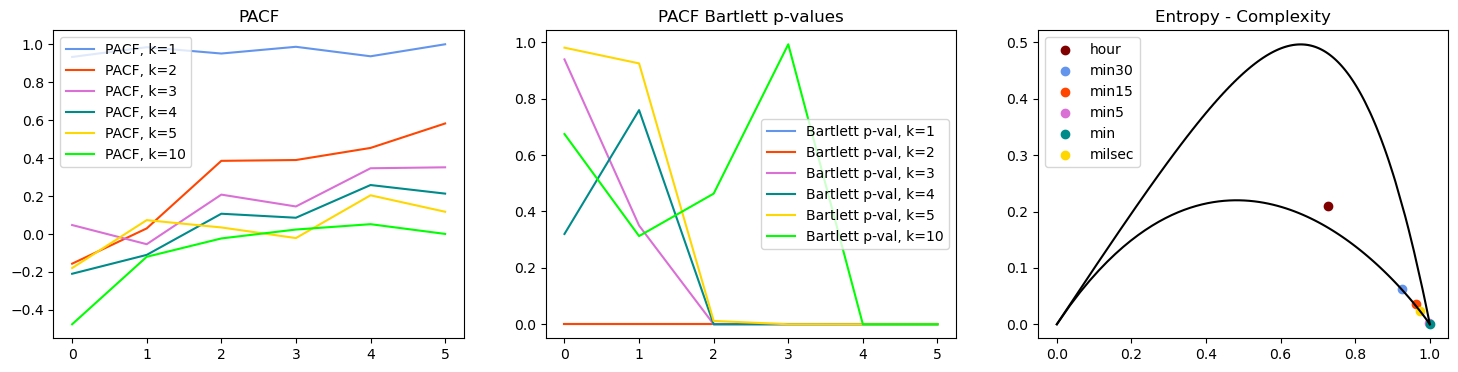

SBER s


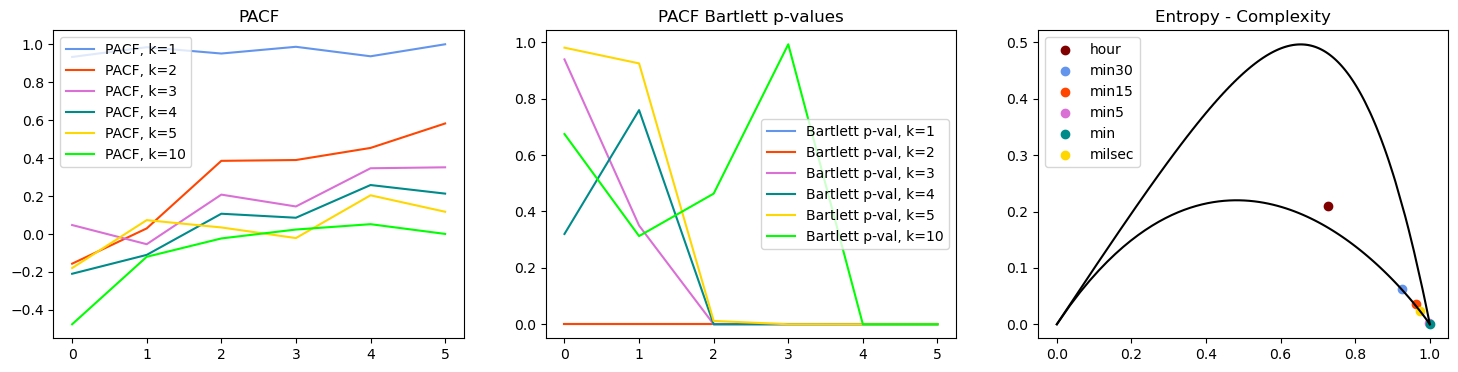

TRUR b


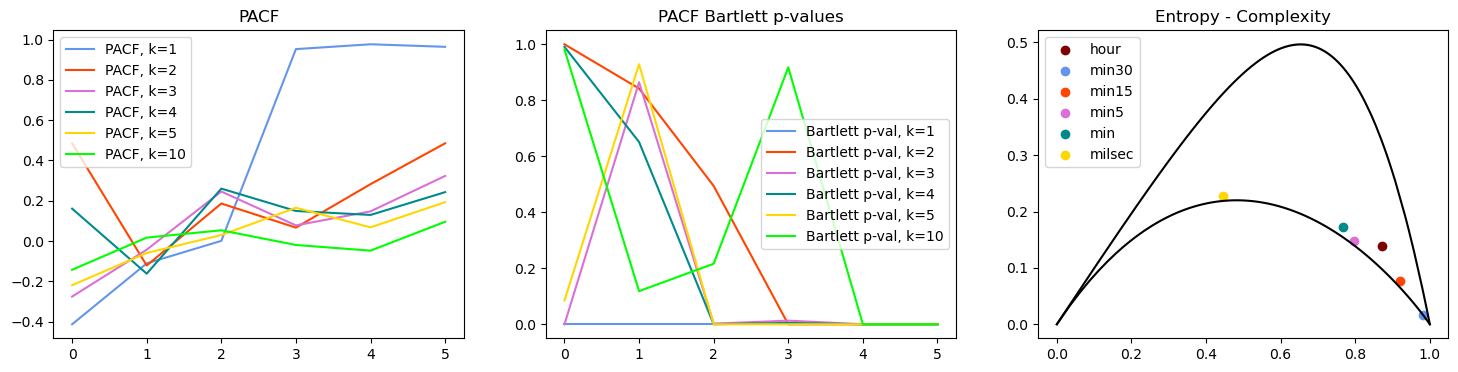

TRUR s


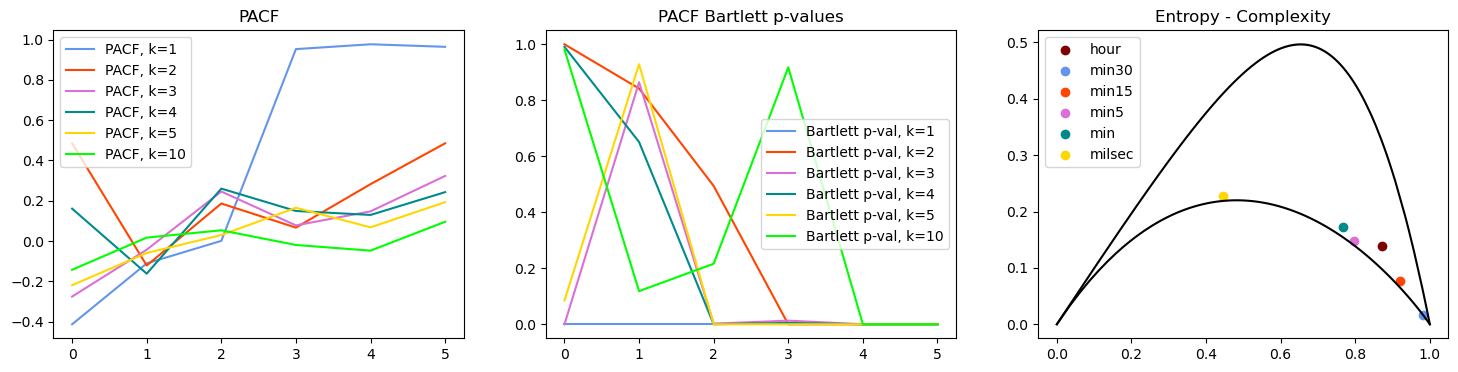

GAZP b


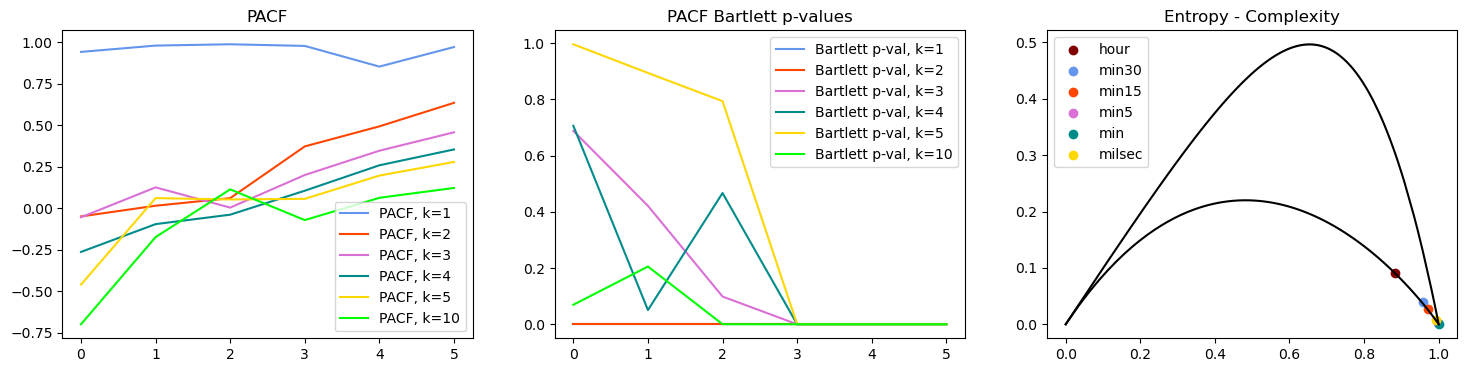

GAZP s


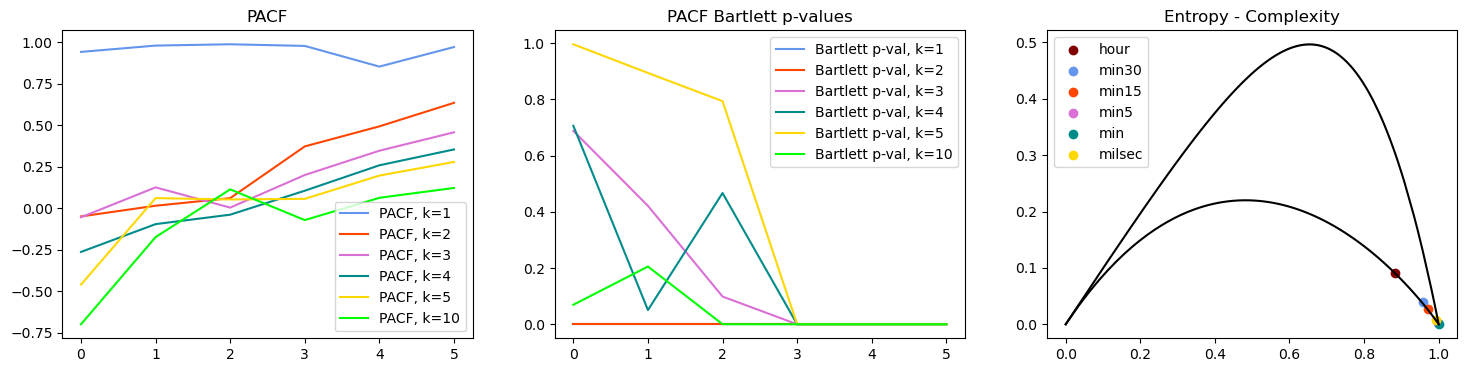

LKOH b


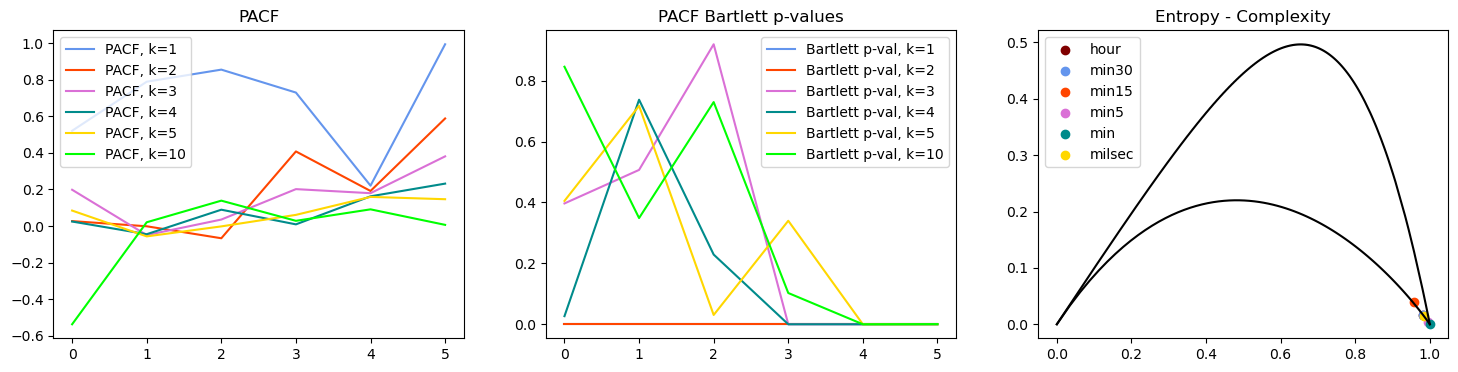

LKOH s


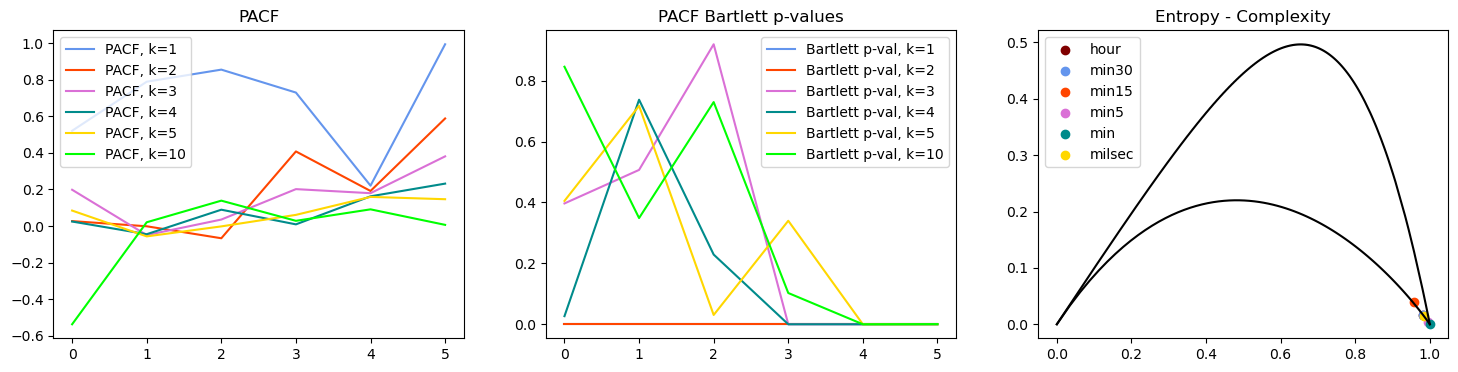

YNDX b


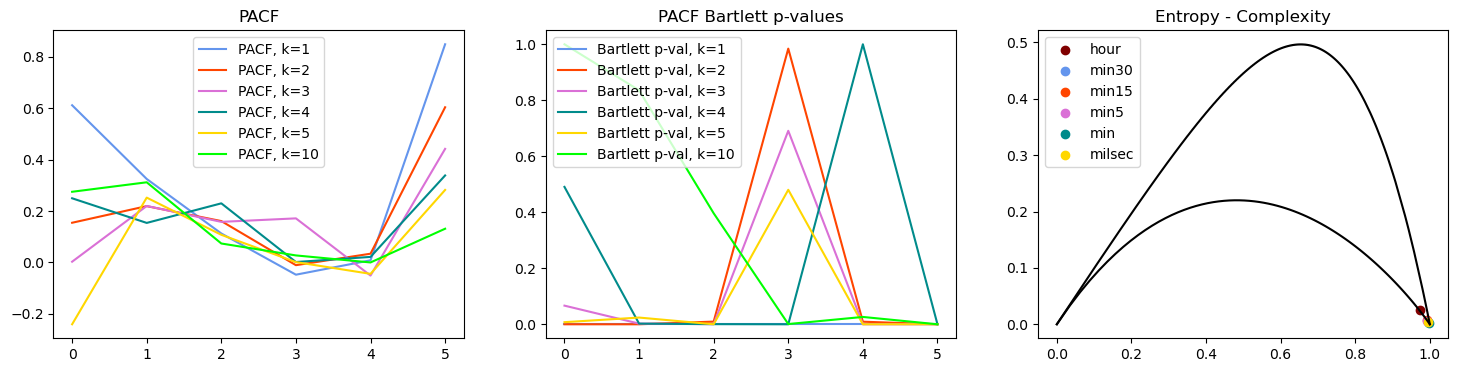

YNDX s


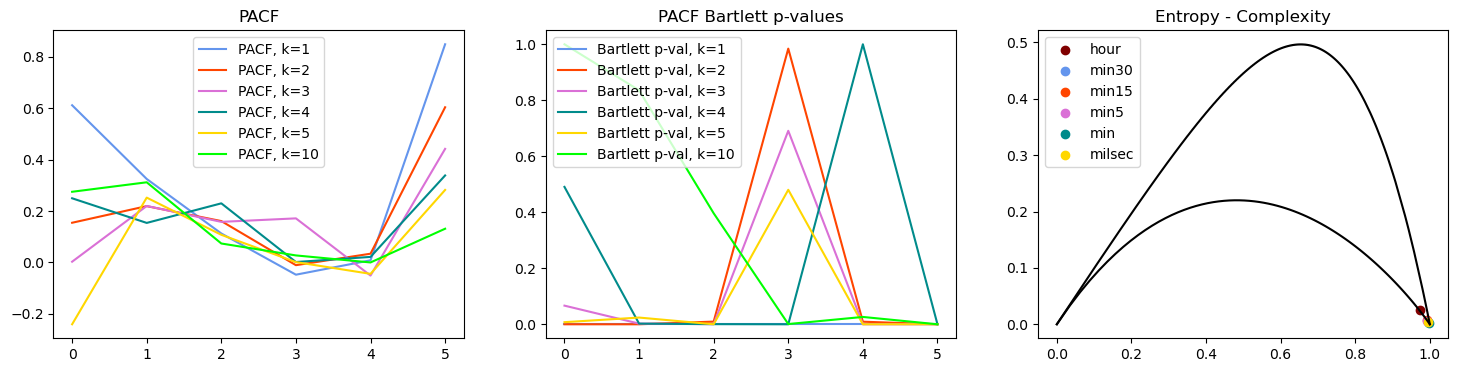

VTBR b


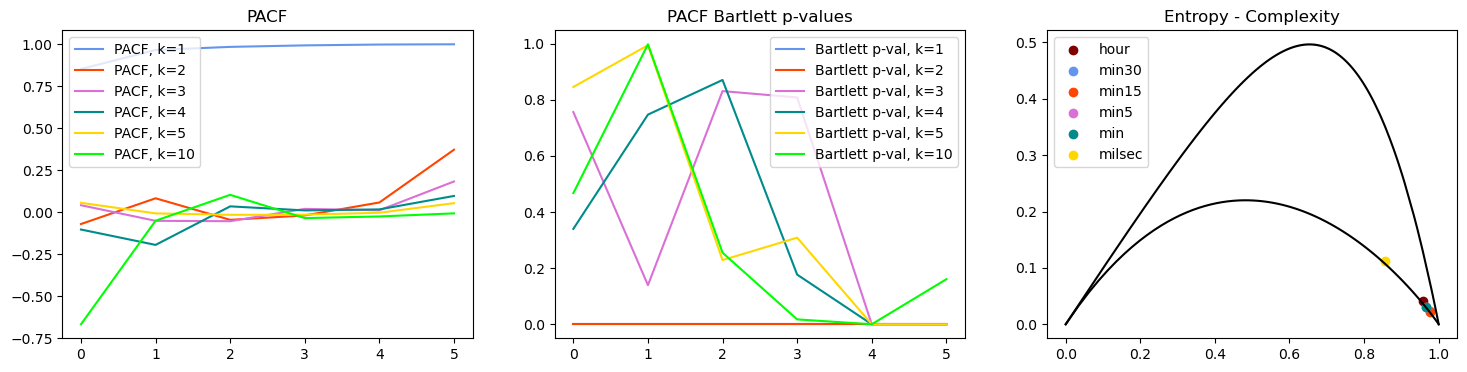

VTBR s


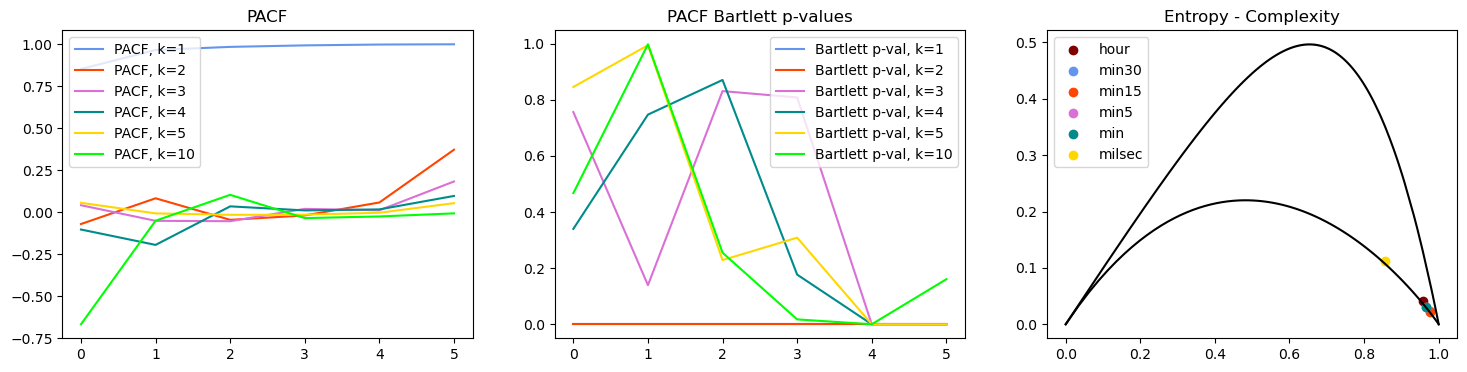

TCSG b


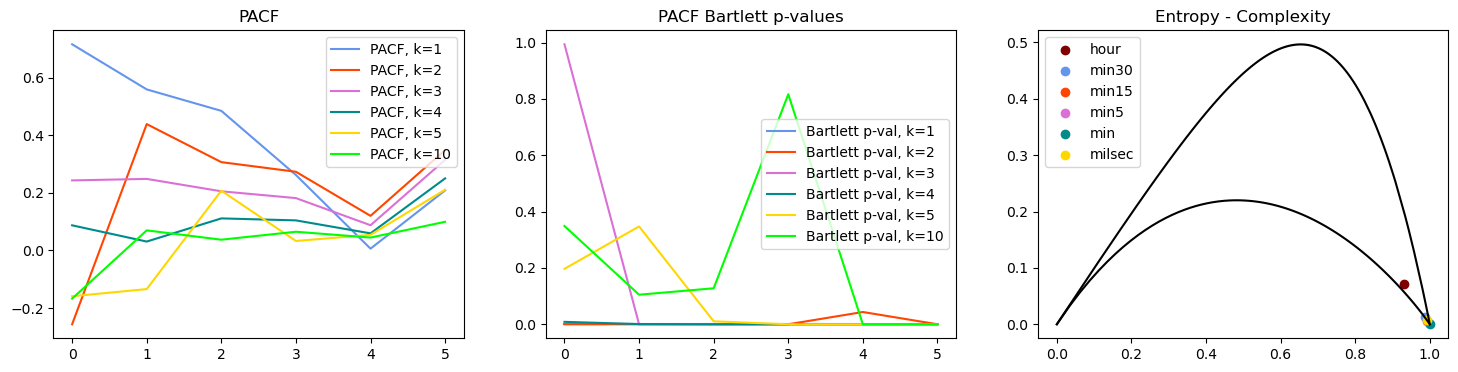

TCSG s


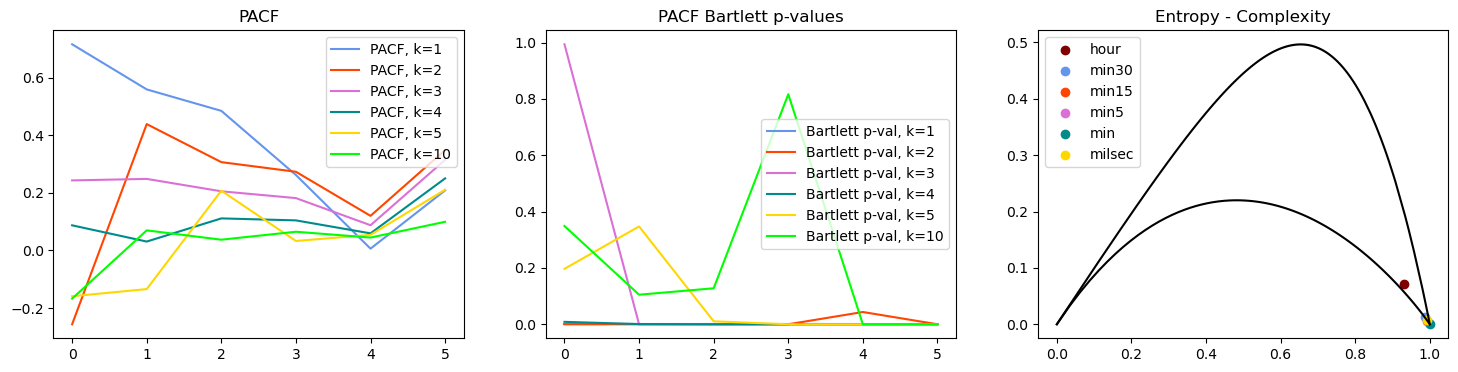

NVTK b


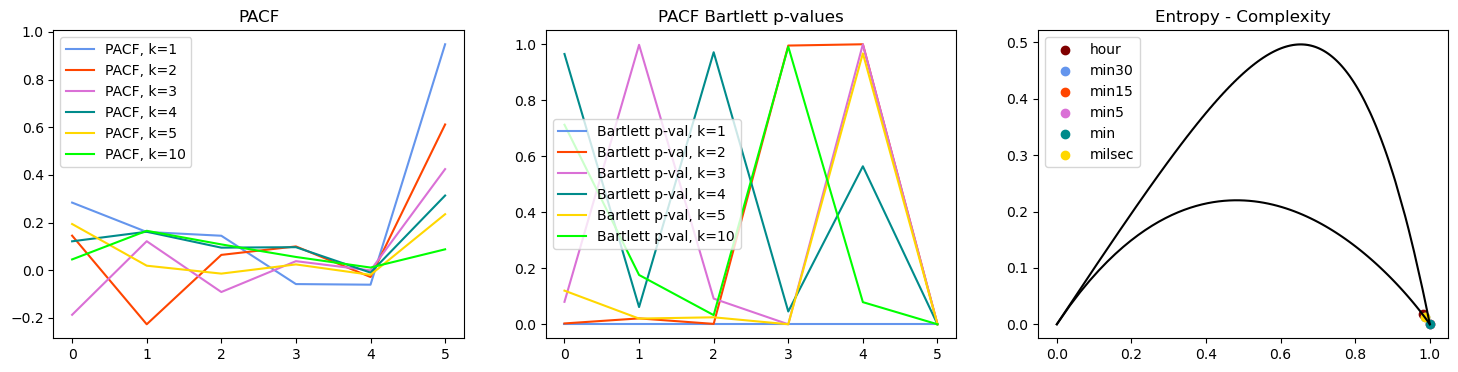

NVTK s


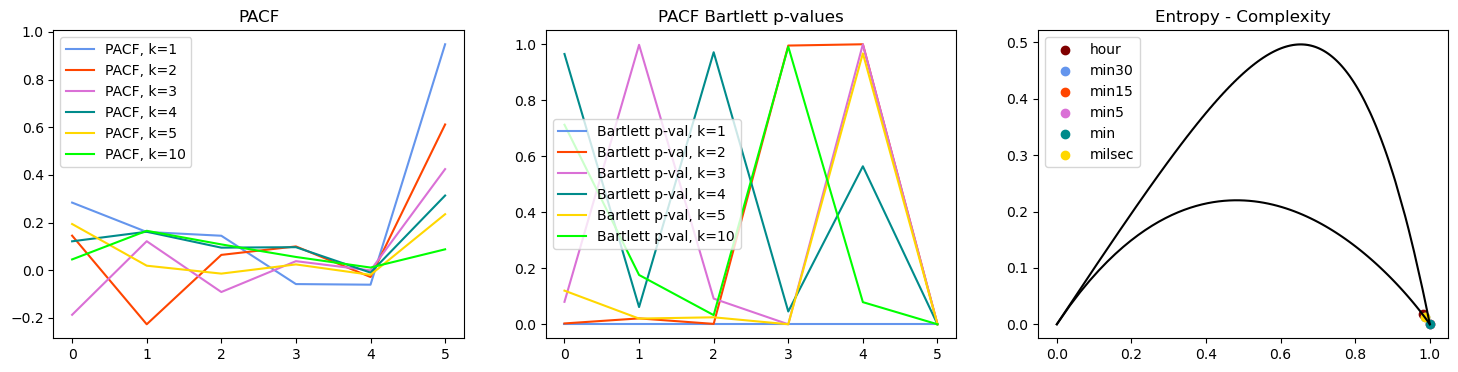

ROSN b


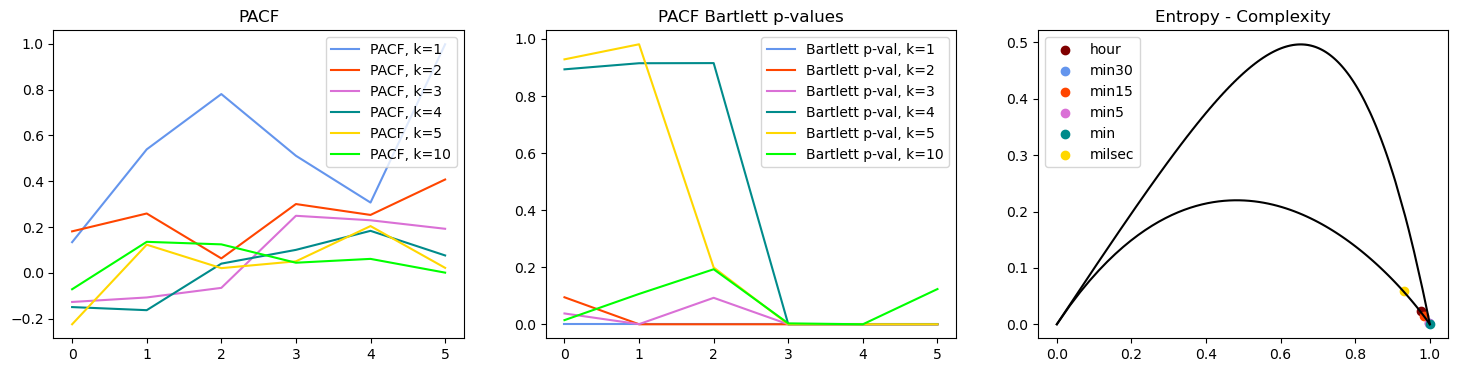

ROSN s


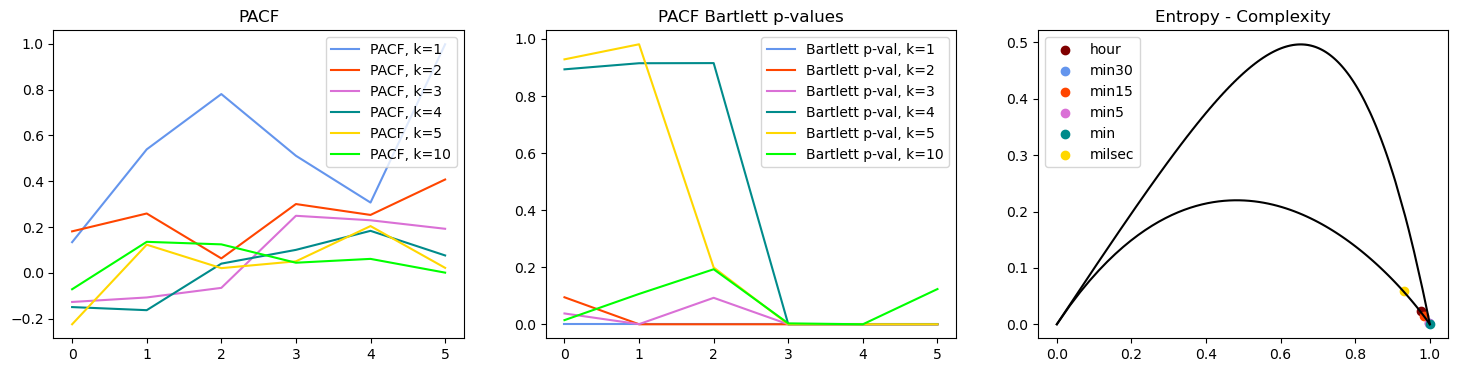

In [16]:
for seccode in ['SBER', 'TRUR', 'GAZP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    for b_or_s in ['b', 's']:
        print(seccode, b_or_s)
        s2n = signal2noise(seccode=[seccode, b_or_s])
        s2n.plot()

SBER b


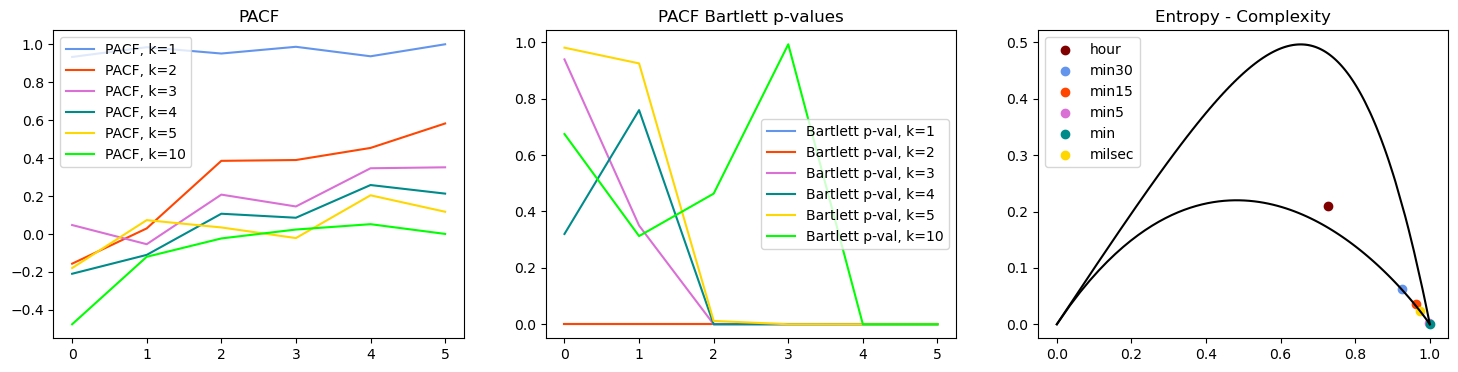

TRUR b


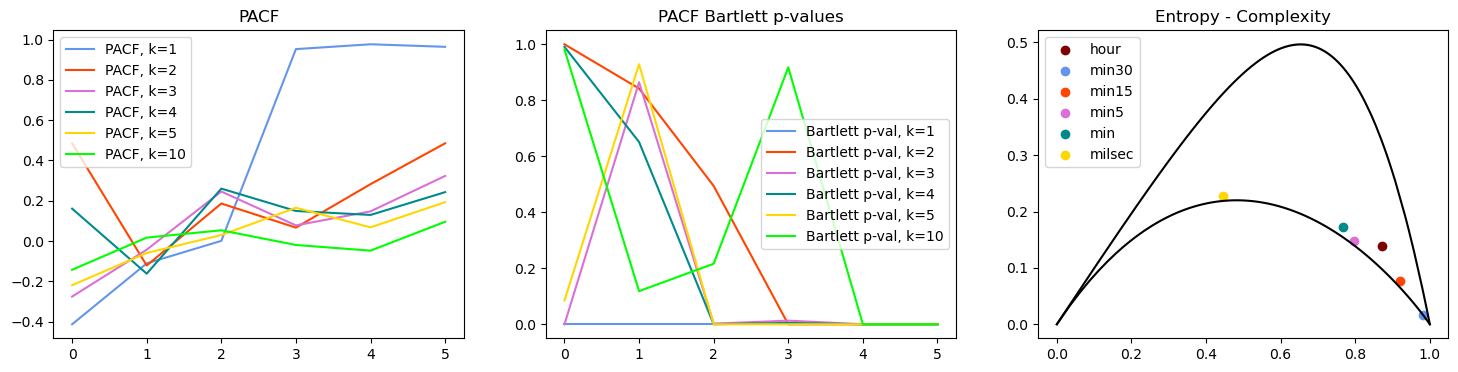

GAZP b


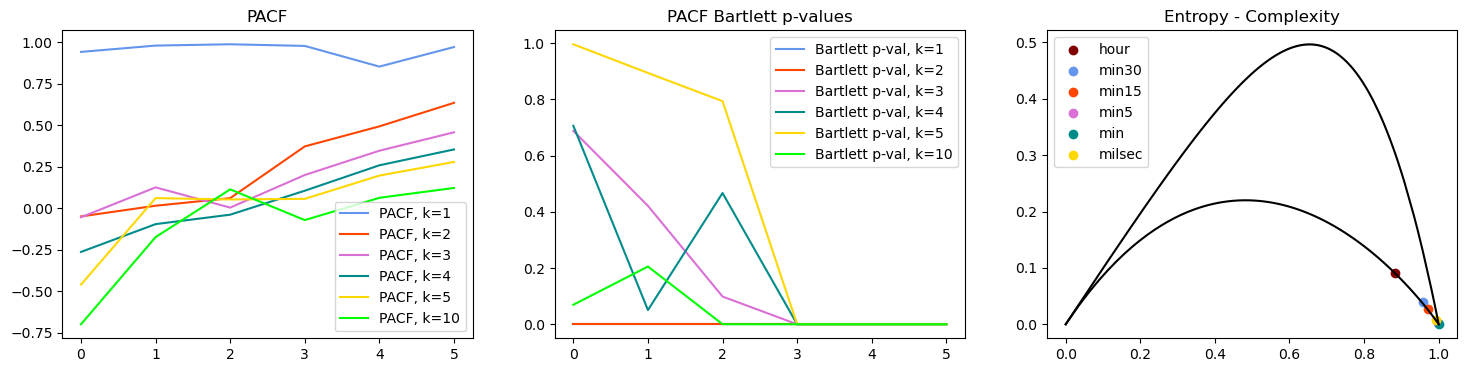

SBERP b


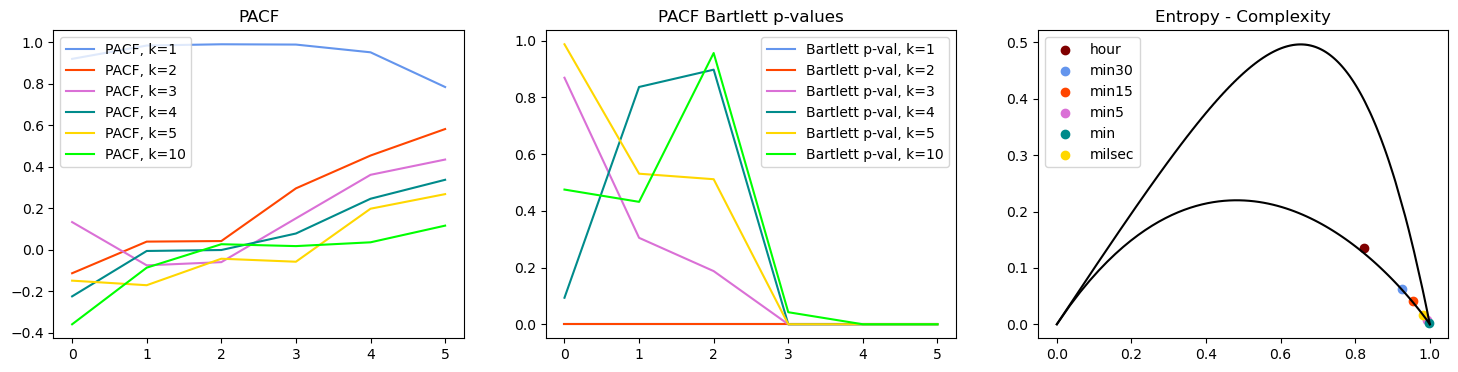

LKOH b


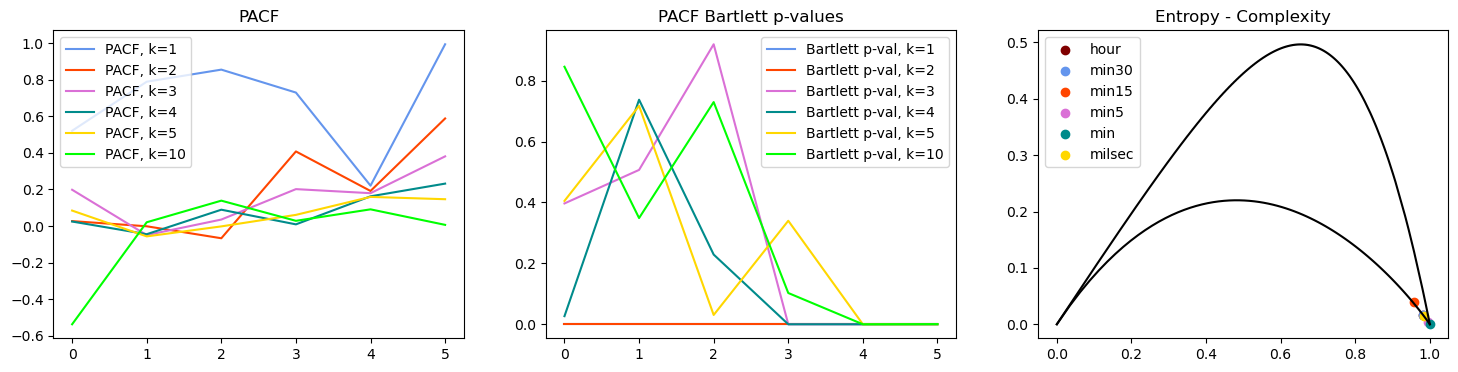

YNDX b


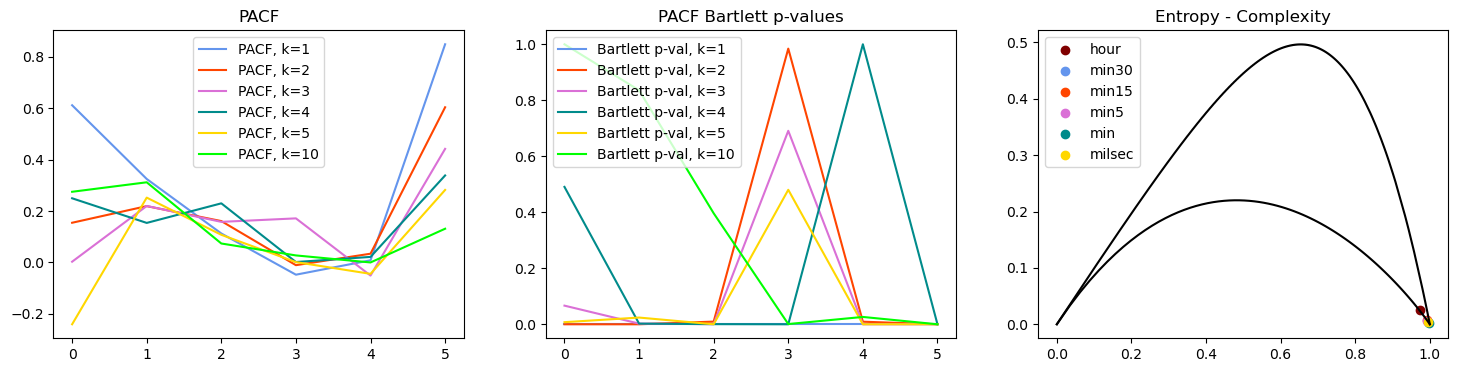

VTBR b


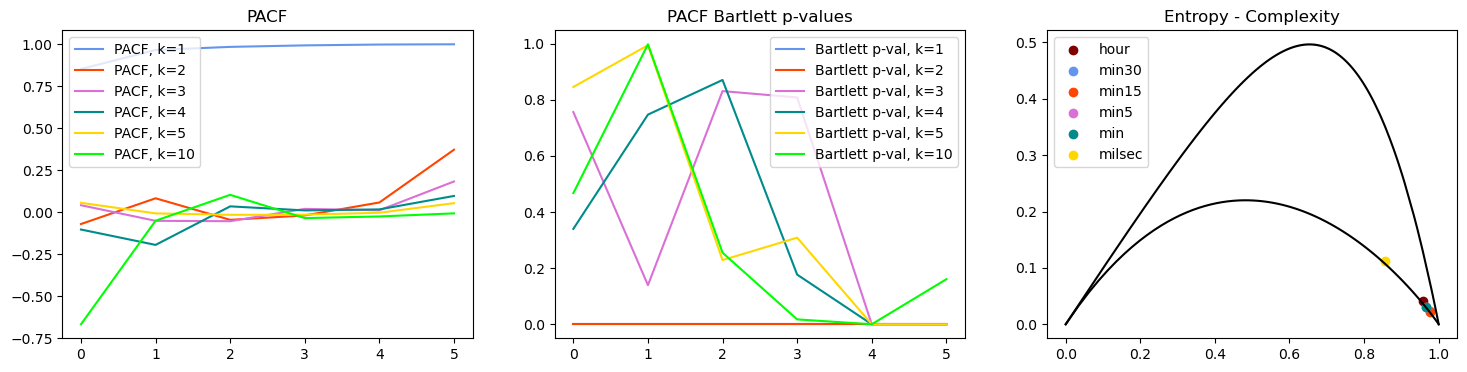

TCSG b


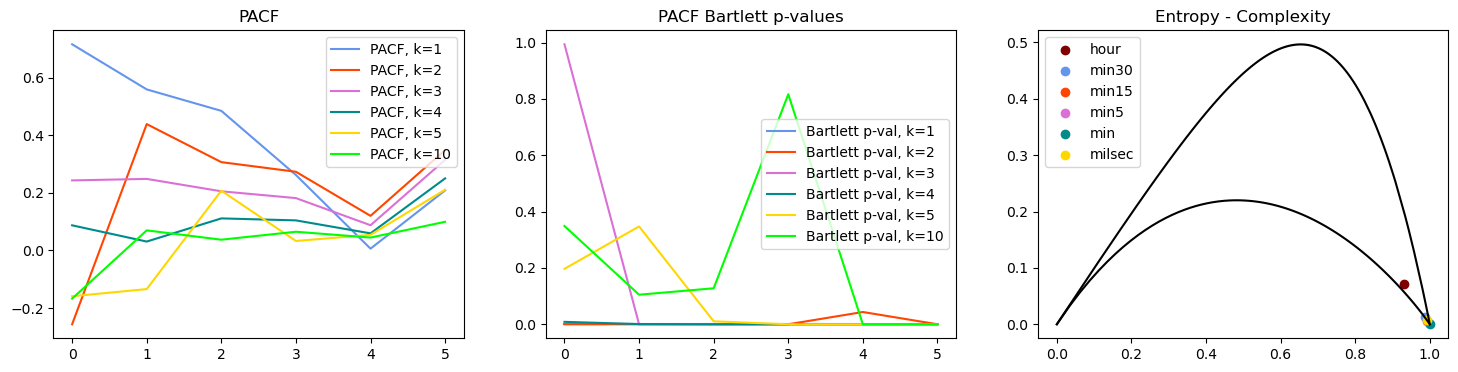

NVTK b


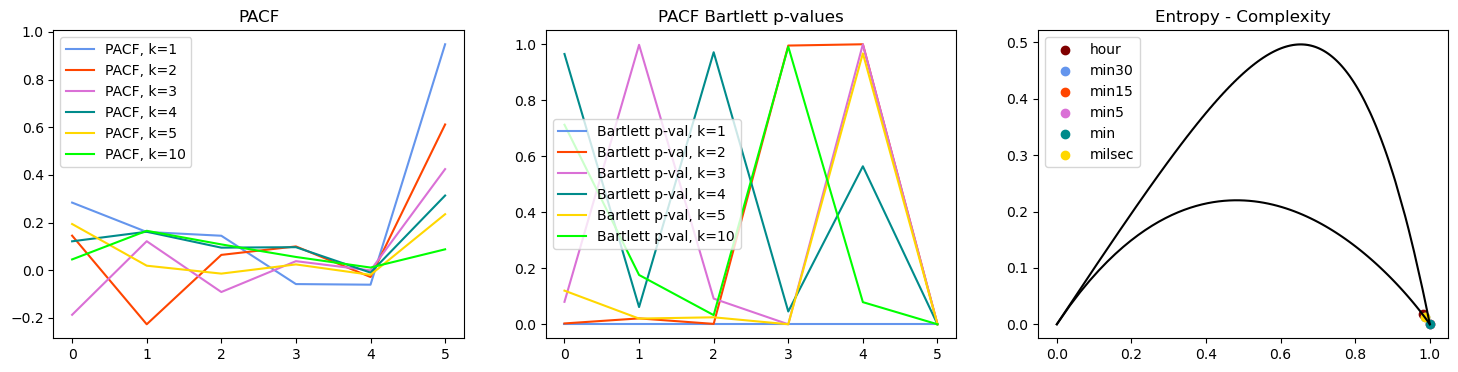

ROSN b


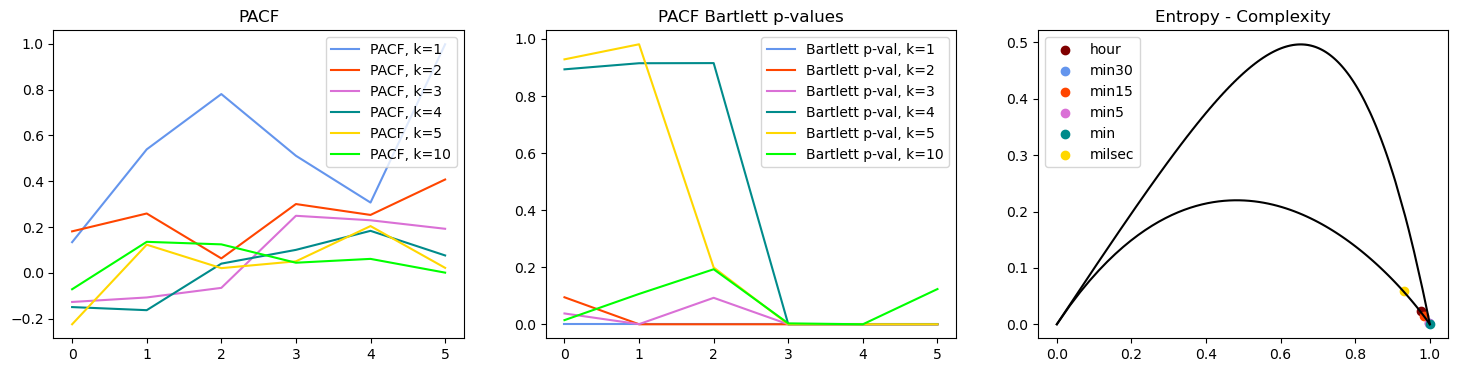

In [10]:
for seccode in ['SBER', 'TRUR', 'GAZP', 'SBERP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    for b_or_s in ['b']:
        print(seccode, b_or_s)
        s2n = signal2noise(seccode=[seccode, 'b'])
        s2n.plot()
        s2n.save_entropy_complexity_plot()

In [13]:
# сохранение

ncols = 5
nrows = 2
img_width, img_height = 600, 500
label_height = 30  

image_folder = '/Users/mariapavleeva/Diplom_FTiAD/s_2_n'
images = []
filenames = []

for seccode in ['SBER', 'TRUR', 'GAZP', 'SBERP', 'LKOH', 'YNDX', 'VTBR', 'TCSG', 'NVTK', 'ROSN']:
    for b_or_s in ['b']:
        filename = f"{seccode}_b.jpeg"
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).resize((img_width, img_height))
        images.append(img)
        filenames.append(filename)

c = Image.new('RGB', (ncols * img_width, nrows * (img_height + label_height)), color='white')
draw = ImageDraw.Draw(c)

font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
font = ImageFont.truetype(font_path, 30)

for i, (img, name) in enumerate(zip(images, filenames)):
    row = i // ncols
    col = i % ncols
    x = col * img_width
    y = row * (img_height + label_height)

    c.paste(img, (x, y + label_height))

    label = os.path.splitext(name)[0]  
    draw.text((x + 10, y), label, fill="black", font=font)
output_path = "/Users/mariapavleeva/Diplom_FTiAD/s_2_n/all_entropy_complexity_noises.jpeg"
c.save(output_path)